<a href="https://colab.research.google.com/github/Pambao/MIP/blob/main/Problem_Set_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install xlrd

In [2]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw, ImageFont

## Step 1: Visualize data

In [9]:
# This function used to draw contour of object to visualize
def draw_object(image, annotations):
  labels = {0: 'rectangle', 1: 'elispe', 2:'polygon'}
  contour_color = (0, 255, 0)
  width = 20
  draw = ImageDraw.Draw(image, mode = 'RGB')
  for annotation in annotations.split(';'):
    annotation = list(map(int, annotation.split(' ')))
    if annotation[0] == 0:
      draw.rectangle(annotation[1:], outline=contour_color, width=width)
    elif annotation[0] == 1:
      draw.ellipse(annotation[1:], outline=contour_color, width=width)
    elif annotation[0] == 2:
      annotation.append(annotation[1])
      annotation.append(annotation[2])
      draw.line(annotation[1:], fill=contour_color, width=width)
    draw.text(
        (annotation[1], annotation[2] - width), 
        labels.get(annotation[0]),
        fill = 'red',
        font=ImageFont.truetype('/content/drive/MyDrive/MIP Resource/arial.ttf', 100)
        )

8000 pictures in /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/train
1000 pictures in /content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/dev


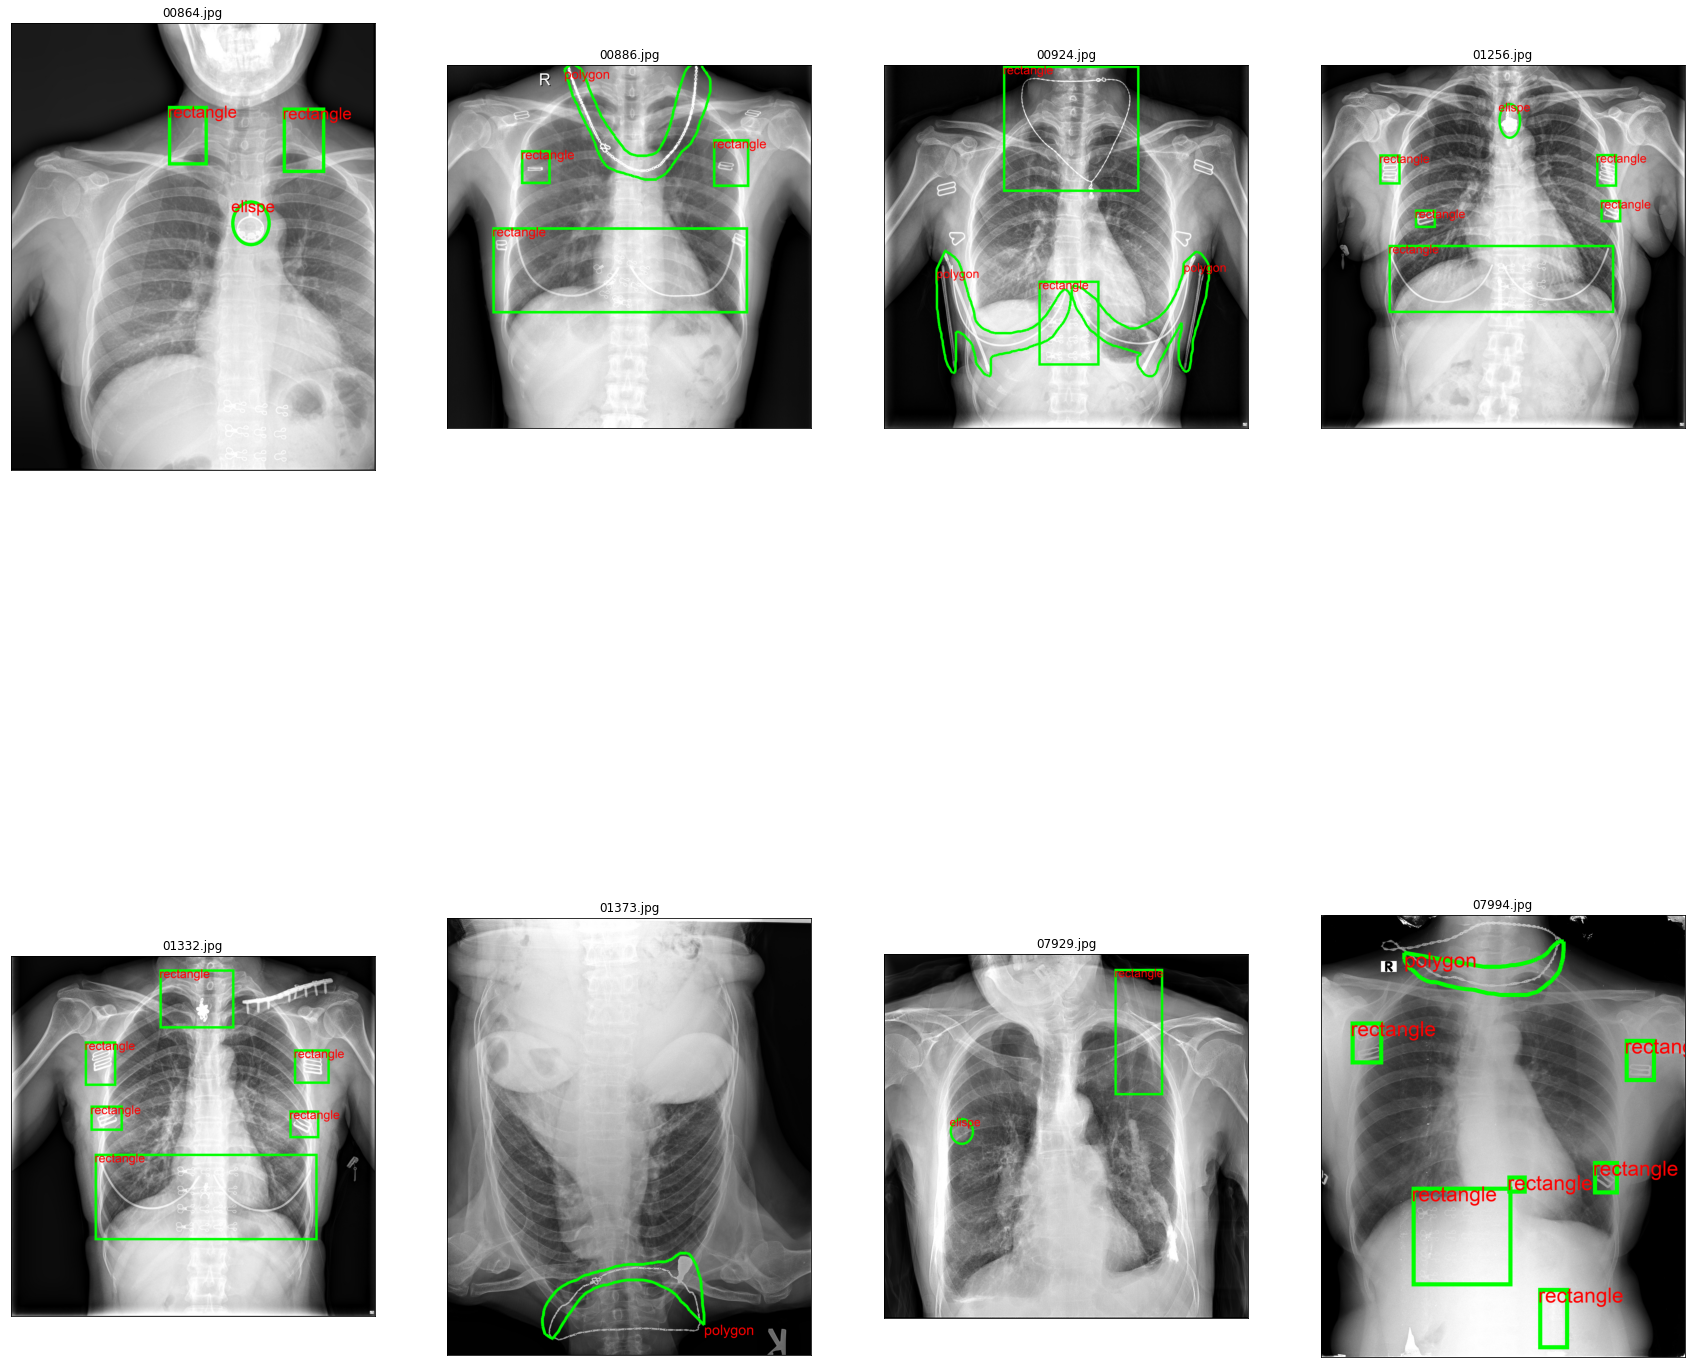

In [10]:
DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/'
SUBDIR = ['train', 'dev']

for dir in SUBDIR:
  print(f'{len(os.listdir(DIRECTORY + dir))} pictures in {DIRECTORY}{dir}')

samples = [864, 886, 924, 1256, 1332, 1373, 7929, 7994]
fig, axs = plt.subplots(2, 4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(30, 30))
axs = list(axs[0]) + list(axs[1])

file = open(DIRECTORY + 'train.csv')
csv_file = list(csv.reader(file))

# Iterate images through sample list and get its annotations
for sample, ax in zip(samples, axs):
  line = csv_file[sample]
  image_name = line[0]
  annotations = line[1]
  image = Image.open(DIRECTORY + 'train/' + image_name).convert('RGB')
  draw_object(image, annotations)
  ax.set_title(image_name)
  ax.imshow(image)

## Build custom dataset

In [58]:
import csv
import os

from pathlib import Path
from PIL import Image

In [11]:
% cd /content/drive/MyDrive/MIP Resource/ChestXrayDataSet

/content/drive/MyDrive/MIP Resource/ChestXrayDataSet


In [12]:
!mkdir customDataSet

In [57]:
DIRECTORY = '/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/'
CATEGORIES = ['train', 'dev']

lables_path = Path(f'{DIRECTORY}lables')
lables_path.mkdir(parents=True, exist_ok=True)
for category in CATEGORIES:
  lables_path = Path(f'{DIRECTORY}labels/{category}')
  lables_path.mkdir(parents=True, exist_ok=True)

  file = open(DIRECTORY + category + '.csv')
  csv_file = list(csv.reader(file))
  for line in csv_file[1:]:
    image_id = (line[0].split('.'))[0]
    image_lable_file = f'{image_id}.txt'
    labels_file = open(f'{DIRECTORY}labels/{category}/{image_lable_file}', mode = 'w')
    if(line[1] != ''):
      image = Image.open(DIRECTORY + category + '/' + image_id +'.jpg')  
      size = image.size
      annotations = line[1].split(';')
      for annotation in annotations:
        class_index = list(map(int, annotation.split(' ')))[0]
        annotation = list(map(int, annotation.split(' ')))[1:]
        list_x = []
        list_y = []
        for index, val in enumerate(annotation):
            if index % 2 == 0:
              list_x.append(val)
            else:
              list_y.append(val)
        max_x = max(list_x) / size[0]
        min_x = min(list_x) / size[0]
        max_y = max(list_y) / size[1]
        min_y = min(list_y) / size[1]
        width = max_x - min_x
        height = max_x - min_x
        center_x = width / 2
        center_y = height / 2

        formated_annotation = f'{class_index} {center_x} {center_y} {width} {height}\n' 
        labels_file.write(formated_annotation)
      labels_file.close()

In [62]:
f = open('/content/drive/MyDrive/MIP Resource/ChestXrayDataSet/object-CXR/labels/train/07992.txt', 'r')
for line in f:
  print(line)


0 0.3937751004016064 0.3937751004016064 0.7875502008032128 0.7875502008032128

0 0.030321285140562246 0.030321285140562246 0.06064257028112449 0.06064257028112449

0 0.05140562248995984 0.05140562248995984 0.10281124497991968 0.10281124497991968

0 0.03373493975903613 0.03373493975903613 0.06746987951807226 0.06746987951807226

0 0.0439759036144578 0.0439759036144578 0.0879518072289156 0.0879518072289156

